In [251]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gymnasium as gym
import numpy as np
import pandas as pd
import pygame
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.spaces import Box
from gymnasium.spaces import Discrete

from paths import DATA_PATH

from torch.utils.data import Dataset, DataLoader
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

In [22]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv')
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


In [91]:
target_df = pd.concat([
    df.high, df.low, df.volume, 
    df.open,                    
    df.close], axis=1)
target_df

,high,low,volume,open,close
0,126.41,120.90,580965.0,124.30,121.11
1,126.41,120.90,580965.0,124.30,121.11
2,126.41,120.90,580965.0,124.30,121.11
3,126.41,120.90,580965.0,124.30,121.11
4,126.41,120.90,580965.0,124.30,121.11
...,...,...,...,...,...
30609,240.93,233.42,11352.0,235.83,237.06
30610,240.93,233.42,11352.0,235.83,237.06
30611,240.93,233.42,11352.0,235.83,237.06
30612,240.93,233.42,11352.0,235.83,237.06


In [89]:
test_size = 0.22
n_samples = target_df.shape[0]

X = target_df.iloc[:, :-1]
y = target_df.iloc[:, -1]

df_train = target_df[:n_samples - int(n_samples * test_size)]
df_test = target_df[-int(n_samples * test_size):]

x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [86]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.obs_size = X.shape[1]
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy()[:,np.newaxis])
        self.index = X.index

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
batch_size = 100


train_dataset = StockDataset(x_train, y_train)
test_dataset = StockDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size=batch_size)

(89.33, 252.65, 35.91763811975256)

In [2]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Episode finished after 200 timesteps


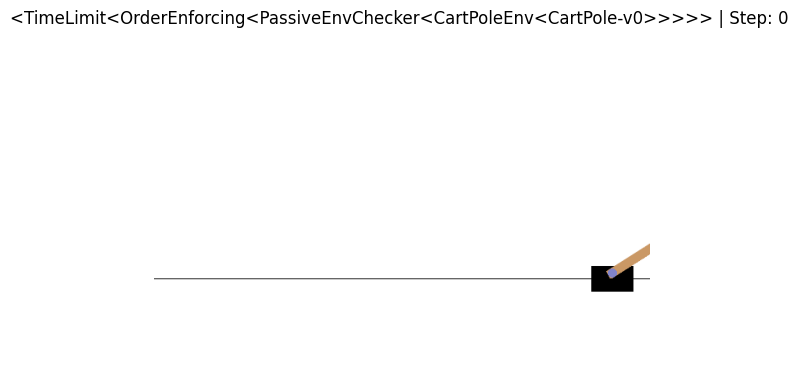

In [10]:
import gymnasium as gym

env = gym.make('CartPole-v0', render_mode='rgb_array')
observation = env.reset()
for t in range(200):
#    env.render()
    print(observation)
    show_state(env)
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    if done:
        display.clear_output(wait=True)
        print("Episode finished after {} timesteps".format(t+1))
#         break


env.close()


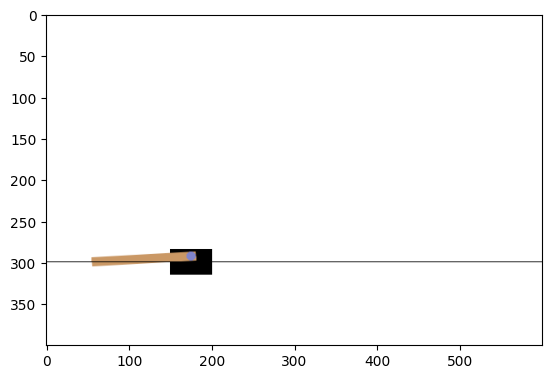

In [14]:
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render()) # only call this once
for _ in range(100):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [249]:
class StocksEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, df, render_mode=None, size=5, fps=4):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

    
        self._original_df = df
        
        self._scaler = MinMaxScaler()
        
        df = pd.DataFrame(self._scaler.fit_transform(df), columns=df.columns)


#         df = pd.DataFrame(scaler.inverse_transform(target_df), columns=df.columns)
        
        X = df.iloc[:, :-1]
        self._X = X
        y = df.iloc[:, -1]
        self._y = y
        
        self._taget_column_name = self._y.name
        
                
        self._action_indent = 1e-3
        action_min = y.min() - self._action_indent
        self._action_min = action_min
        action_max = y.max() + self._action_indent
        self._action_max = action_max    

        self._initial_taget_location = y[0]
        
        feature_number = X.shape[1]

        self._dataset = StockDataset(X, y)
        

        
        #observing current state of market and news
        describe = X.describe()
        self.observation_space = spaces.Box(
            low=describe.loc['min'].to_numpy(),
            high=describe.loc['max'].to_numpy(),
            shape=(feature_number,), dtype=np.float32
        )


        # prediction of to buy or to sell relatively
#         self.action_space = spaces.Box(
#             low=-max_action_bound, 
#             high=+max_action_bound,
#             dtype=np.float32,
#         )
        # prediction of close price
        self.action_space = spaces.Box(
            low = action_min, 
            high = action_max,
            dtype=np.float32,
        )

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        

        
    def _get_obs(self):
        features, target = self._dataset[self._current_dataset_idx]
        return features
    
    
    def _get_info(self):
        return self._current_dataset_idx
    

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self._agent_history = []

#         self._agent_location = self.np_random.integers(self._obs_min, self._obs_max, size=1, dtype=np.float32)
        self._agent_location = self._initial_taget_location

        self._target_location = self._initial_taget_location
        
        self._current_dataset_idx = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()


        return observation, info

    def step(self, action):     
        self._agent_history.append(action)
        

        terminated = self._current_dataset_idx >= len(self._dataset) - 1

        target = self._y[self._current_dataset_idx]

        
        reward = 1 / np.abs(action - target)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        
        self._current_dataset_idx += 1
        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

        
    def _inv_transform(self, data):
        scaler = self._scaler
        dummy = pd.DataFrame(np.zeros((len(data), len(self._original_df.columns))), columns=self._original_df.columns)
        dummy[self._taget_column_name] = data
        return scaler.inverse_transform(dummy)
                             

    def _render_frame(self):
        target = self._y[:self._current_dataset_idx]
        agent = self._agent_history


        plt.figure(3)
        plt.clf()
        plt.cla()
        plt.plot(target, label='target')
        plt.plot(agent, label='agent')
        
        plt.title("%s | Step: %d" % (env, self._current_dataset_idx))
        plt.ylim((target.min()-0, target.max()+0))
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


In [250]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

NameError: name 'nn' is not defined

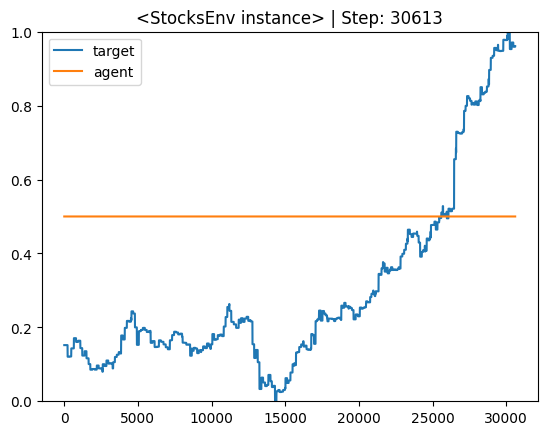

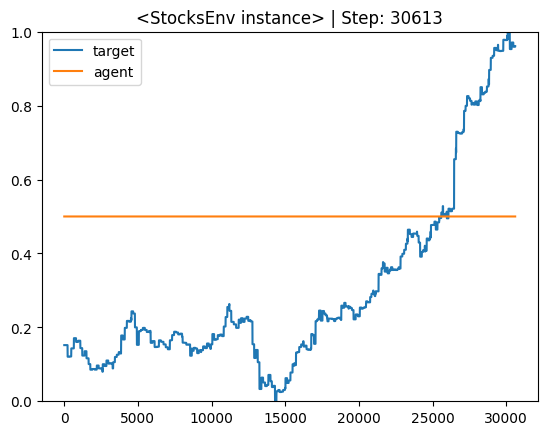

In [248]:
env = StocksEnv(target_df, render_mode="rgb_array")


observation, info = env.reset(seed=42)


for i in range(1000000):
#     action = env.action_space.sample()
    action = np.array([0.5])
    
    observation, reward, terminated, truncated, info = env.step(action)
    if i % 1000 == 0:
#         env.render()
        pass

    if terminated or truncated:
        env.render()
        observation, info = env.reset()
        break


env.close()

In [246]:
env._current_dataset_idx

0